In [ ]:
import zipfile
import os
import random
import copy
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision
from torchvision import models
from sklearn.utils import shuffle
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.font_manager
from collections import OrderedDict

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
zip_file_path = '/content/drive/MyDrive/EC523-Project/data/zip/food101_10percent.zip'

# Unzipping the Food-101 dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/train')

# The Food-101 dataset is now unzipped in '/content/train'
# Listing the categories/directories in the dataset
classes = sorted(os.listdir('/content/train/food101_10percent/train'))

zip_file_path = '/content/drive/MyDrive/EC523-Project/data/zip/food101_test.zip'
# Unzipping the Food-101 dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/train')

classes = sorted(os.listdir('/content/train/food101_10percent/train'))

In [ ]:
# Assuming the Food-101 dataset is unzipped in '/content/food-101'
train_images_path = '/content/train/food101_10percent/train'
test_images_path = '/content/train/food101_test'
# Lists to store training and testing data paths
train_data = []
test_data = []


for food_category in os.listdir(train_images_path):
    category_path = os.path.join(train_images_path, food_category)
    images = os.listdir(category_path)
    train_images = images[:]

    # Add image paths to the train and test lists
    train_data.extend([f"{food_category}/{img}" for img in train_images])

for food_category in os.listdir(test_images_path):
    category_path = os.path.join(test_images_path, food_category)
    images = os.listdir(category_path)
    test_images = images[:]
    # Add image paths to the train and test lists
    test_data.extend([f"{food_category}/{img}" for img in test_images])

directory_path = '/content/train/meta'

# Create the directory if it doesn't exist
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory '{directory_path}' created.")

# File path for the file to create within the directory
file_path = os.path.join(directory_path, 'train.txt')
file_path = os.path.join(directory_path, 'test.txt')
file_path = os.path.join(directory_path, 'classes.txt')


# Write the train and test data to files
with open('/content/train/meta/train.txt', 'w') as f:
    for item in train_data:
        f.write("%s\n" % item)

with open('/content/train/meta/test.txt', 'w') as f:
    for item in test_data:
        f.write("%s\n" % item)

with open('/content/train/meta/classes.txt', 'w') as f:
    for item in classes:
        f.write("%s\n" % item)

# Display the first 5 lines of each file as a sample
print("Testing images")
print("\n".join(test_data[:5]))
print("\nTraining images")
print("\n".join(train_data[:5]))

Directory '/content/train/meta' created.
Testing images
prime_rib/1006976.jpg
prime_rib/1570554.jpg
prime_rib/2905369.jpg
prime_rib/2903673.jpg
prime_rib/1850880.jpg

Training images
prime_rib/1075876.jpg
prime_rib/2853207.jpg
prime_rib/1198998.jpg
prime_rib/3358918.jpg
prime_rib/279387.jpg


In [ ]:
classes = open("/content/train/meta/classes.txt", 'r').read().splitlines()

In [ ]:
train_df = pd.read_csv('/content/train/meta/train.txt', header = None, names=['path'])
train_df.head()

,path
0,prime_rib/1075876.jpg
1,prime_rib/2853207.jpg
2,prime_rib/1198998.jpg
3,prime_rib/3358918.jpg
4,prime_rib/279387.jpg


In [ ]:
test_df = pd.read_csv('/content/train/meta/test.txt', header = None, names=['path'])
test_df.head()

,path
0,prime_rib/1006976.jpg
1,prime_rib/1570554.jpg
2,prime_rib/2905369.jpg
3,prime_rib/2903673.jpg
4,prime_rib/1850880.jpg


In [ ]:
def spliter(data, class_or_id='id'):
    if class_or_id.upper() == 'CLASS':
        output = data.split('/')[0]

    else:
        output = data.split('/')[-1]
    return output

In [ ]:
train_df['label'] = train_df['path'].map(lambda x: spliter(data = x, class_or_id = 'Class'))
train_df.head()

,path,label
0,prime_rib/1075876.jpg,prime_rib
1,prime_rib/2853207.jpg,prime_rib
2,prime_rib/1198998.jpg,prime_rib
3,prime_rib/3358918.jpg,prime_rib
4,prime_rib/279387.jpg,prime_rib


In [ ]:
train_df['idx'] = train_df['path'].map(lambda x: spliter(x))
train_df.head()

,path,label,idx
0,prime_rib/1075876.jpg,prime_rib,1075876.jpg
1,prime_rib/2853207.jpg,prime_rib,2853207.jpg
2,prime_rib/1198998.jpg,prime_rib,1198998.jpg
3,prime_rib/3358918.jpg,prime_rib,3358918.jpg
4,prime_rib/279387.jpg,prime_rib,279387.jpg


In [ ]:
test_df['label'] = test_df['path'].map(lambda x: spliter(x, 'class'))
test_df['idx'] = test_df['path'].map(lambda x: spliter(x))
test_df.head()

,path,label,idx
0,prime_rib/1006976.jpg,prime_rib,1006976.jpg
1,prime_rib/1570554.jpg,prime_rib,1570554.jpg
2,prime_rib/2905369.jpg,prime_rib,2905369.jpg
3,prime_rib/2903673.jpg,prime_rib,2903673.jpg
4,prime_rib/1850880.jpg,prime_rib,1850880.jpg


In [ ]:
mini_20 = train_df['label'].unique()[:101]
mini_20 = [f.upper() for f in mini_20]
mini_20

['PRIME_RIB',
 'FRENCH_FRIES',
 'ONION_RINGS',
 'CLUB_SANDWICH',
 'FISH_AND_CHIPS',
 'MUSSELS',
 'CARROT_CAKE',
 'BIBIMBAP',
 'BAKLAVA',
 'CHOCOLATE_CAKE',
 'MACARONS',
 'FOIE_GRAS',
 'CHURROS',
 'BRUSCHETTA',
 'DUMPLINGS',
 'PULLED_PORK_SANDWICH',
 'SUSHI',
 'TUNA_TARTARE',
 'SPAGHETTI_CARBONARA',
 'FROZEN_YOGURT',
 'FRENCH_ONION_SOUP',
 'MACARONI_AND_CHEESE',
 'PANNA_COTTA',
 'PEKING_DUCK',
 'DEVILED_EGGS',
 'MISO_SOUP',
 'FRENCH_TOAST',
 'SPAGHETTI_BOLOGNESE',
 'SEAWEED_SALAD',
 'GRILLED_CHEESE_SANDWICH',
 'DONUTS',
 'CHOCOLATE_MOUSSE',
 'PAD_THAI',
 'CROQUE_MADAME',
 'RISOTTO',
 'FRIED_RICE',
 'PIZZA',
 'CEVICHE',
 'GREEK_SALAD',
 'RAMEN',
 'SPRING_ROLLS',
 'POUTINE',
 'STRAWBERRY_SHORTCAKE',
 'CANNOLI',
 'TACOS',
 'HOT_DOG',
 'CREME_BRULEE',
 'APPLE_PIE',
 'LOBSTER_ROLL_SANDWICH',
 'BEET_SALAD',
 'NACHOS',
 'SCALLOPS',
 'OMELETTE',
 'SASHIMI',
 'HUEVOS_RANCHEROS',
 'GRILLED_SALMON',
 'EDAMAME',
 'CLAM_CHOWDER',
 'BREAKFAST_BURRITO',
 'BEEF_TARTARE',
 'FILET_MIGNON',
 'CHEESECAKE',

In [ ]:
def prepare_data(label):
    if label.upper() in mini_20:
        return label
    else:
        return 'Others'

In [ ]:
train_df['label'] = train_df['label'].map(lambda x: prepare_data(x))
test_df['label'] = test_df['label'].map(lambda x: prepare_data(x))

In [ ]:
train_df['label'].unique()

array(['prime_rib', 'french_fries', 'onion_rings', 'club_sandwich',
       'fish_and_chips', 'mussels', 'carrot_cake', 'bibimbap', 'baklava',
       'chocolate_cake', 'macarons', 'foie_gras', 'churros', 'bruschetta',
       'dumplings', 'pulled_pork_sandwich', 'sushi', 'tuna_tartare',
       'spaghetti_carbonara', 'frozen_yogurt', 'french_onion_soup',
       'macaroni_and_cheese', 'panna_cotta', 'peking_duck',
       'deviled_eggs', 'miso_soup', 'french_toast', 'spaghetti_bolognese',
       'seaweed_salad', 'grilled_cheese_sandwich', 'donuts',
       'chocolate_mousse', 'pad_thai', 'croque_madame', 'risotto',
       'fried_rice', 'pizza', 'ceviche', 'greek_salad', 'ramen',
       'spring_rolls', 'poutine', 'strawberry_shortcake', 'cannoli',
       'tacos', 'hot_dog', 'creme_brulee', 'apple_pie',
       'lobster_roll_sandwich', 'beet_salad', 'nachos', 'scallops',
       'omelette', 'sashimi', 'huevos_rancheros', 'grilled_salmon',
       'edamame', 'clam_chowder', 'breakfast_burrito', 'b

In [ ]:
def add_exact_path_train(path):
    return '/content/train/food101_10percent/train/'+path

def add_exact_path_test(path):
    return '/content/train/food101_test/'+path

In [ ]:
train_df['path'] = train_df[['path']].apply(add_exact_path_train, axis=1)
test_df['path'] = test_df[['path']].apply(add_exact_path_test, axis=1)
train_df.head()

,path,label,idx
0,/content/train/food101_10percent/train/prime_r...,prime_rib,1075876.jpg
1,/content/train/food101_10percent/train/prime_r...,prime_rib,2853207.jpg
2,/content/train/food101_10percent/train/prime_r...,prime_rib,1198998.jpg
3,/content/train/food101_10percent/train/prime_r...,prime_rib,3358918.jpg
4,/content/train/food101_10percent/train/prime_r...,prime_rib,279387.jpg


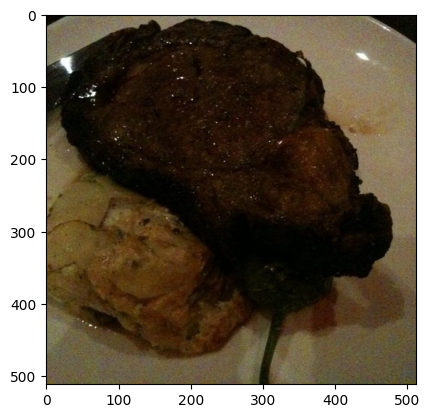

In [ ]:
from matplotlib import pyplot as plt
img = plt.imread(train_df['path'].iloc[0])
plt.imshow(img)

In [ ]:
img.shape

(512, 512, 3)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
test_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_gen = datagen.flow_from_dataframe(dataframe = train_df, directory=None, x_col='path', y_col='label',
    weight_col=None, target_size=(256, 256), color_mode='rgb',
    classes=None, class_mode='categorical', batch_size=32, shuffle=True, validate_filenames=False)

Found 7575 non-validated image filenames belonging to 101 classes.


In [ ]:
test_gen = datagen.flow_from_dataframe(dataframe = test_df, directory=None, x_col='path', y_col='label',
    weight_col=None, target_size=(256, 256), color_mode='rgb',
    classes=None, class_mode='categorical', batch_size=32, shuffle=True, validate_filenames=False)

Found 25250 non-validated image filenames belonging to 101 classes.


In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.xception import Xception

Xception = Xception(weights='imagenet', include_top=False)
x = Xception.output
x = GlobalAveragePooling2D()(x)
x = Dense(256,activation='relu')(x)
# x = Dropout(0.4)(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(101, activation='softmax')(x)

model = Model(inputs=Xception.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
history = model.fit(train_gen,
                              steps_per_epoch = len(train_gen) // 32,
                    epochs=300,
                    verbose=1)


Epoch 1/300
7/7 [==============================] - 47s 624ms/step - loss: 4.6173 - accuracy: 0.0089
Epoch 2/300
7/7 [==============================] - 5s 718ms/step - loss: 4.6169 - accuracy: 0.0134
Epoch 3/300
7/7 [==============================] - 7s 971ms/step - loss: 4.6103 - accuracy: 0.0223
Epoch 4/300
7/7 [==============================] - 6s 756ms/step - loss: 4.6144 - accuracy: 0.0134
Epoch 5/300
7/7 [==============================] - 5s 720ms/step - loss: 4.5766 - accuracy: 0.0446
Epoch 6/300
7/7 [==============================] - 8s 1s/step - loss: 4.5787 - accuracy: 0.0268
Epoch 7/300
7/7 [==============================] - 5s 723ms/step - loss: 4.5446 - accuracy: 0.0268
Epoch 8/300
7/7 [==============================] - 7s 893ms/step - loss: 4.5322 - accuracy: 0.0268
Epoch 9/300
7/7 [==============================] - 6s 824ms/step - loss: 4.4926 - accuracy: 0.0580
Epoch 10/300
7/7 [==============================] - 5s 710ms/step - loss: 4.4747 - accuracy: 0.0491
Epoch 11/30

In [ ]:
result = model.evaluate(test_gen, batch_size=32)
print(result)

790/790 [==============================] - 505s 638ms/step - loss: 1.6280 - accuracy: 0.6267
[1.6279857158660889, 0.6266534924507141]


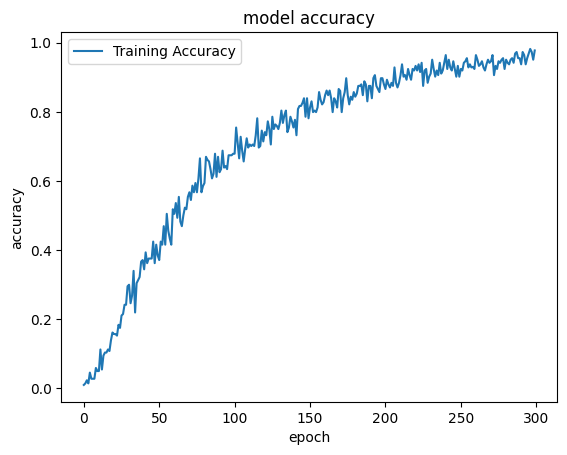

In [ ]:
# Accuracy plot
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy'], loc='upper left')
plt.show()